
# Image Classification

Building a machine learning model to solve Image Classification using the PyTorch framework.<br>
Image Classification is one of the basic pattern recognition exercises. <br>
Using Image files as its input, a model trained for Image classification will split a set of images into a given number of classes. <br>
<br>
This Notebook has been generated automatically using the JupyterLab extension ***MLProvCodeGen***.
<br>
The original Source Code is from this application https://github.com/jrieke/traingenerator <br>
Made by: https://www.jrieke.com/ Twitter: https://twitter.com/jrieke


### Installs
Install required packages before running

In [1]:
#pip install numpy===1.22.2 ipywidgets===7.6.5 torch===1.10.2 torchvision===0.11.3 pytorch-ignite===0.4.6 gputil===1.4.0 psutil===5.9.0 py-cpuinfo===8.0.0 prov===2.0.0 --user
#torch currently not supported with python 3.10, downgrading to python 3.9.7 possibly required


### Imports

In [2]:
import numpy as np
import torch
import ipywidgets as widgets
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision as torchvision
from torchvision import models, datasets, transforms
import ignite as pytorch_ignite
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, ClassificationReport
import GPUtil
import psutil
import cpuinfo
import platform
import datetime
from datetime import date
import time
import json
import webbrowser
import IPython
from IPython.display import display, Image
import prov
from prov.model import ProvDocument
from prov.dot import prov_to_dot
import os

### Provenance Data

In [3]:
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

d1 = ProvDocument()
d1.set_default_namespace('provenanceexample.org')
#set_experiment_info()
d1.add_namespace('experimentinfo', 'experimentinfo.org')
e_experimentinfo = d1.entity('experiment_info', (
    ('experimentinfo:author', 'Tarek Al Mustafa'),
    ('experimentinfo:email', 'tarek.almustafa@uni-jena.de'),
    ('experimentinfo:title', 'Image Classification'),
    ('experimentinfo:creation_date', str(date.today())),
    ('experimentinfo:task_type', 'ImageClassification_pytorch'),
))

a_setexperimentinfo = d1.activity('set_experiment_info()', datetime.datetime.now(), None)
a_setdate = d1.activity('date.today()')

d1.wasGeneratedBy(e_experimentinfo, a_setexperimentinfo, None, {'ex:fct': 'set'})
d1.wasAssociatedWith('experiment_info', 'Tarek Al Mustafa', None, None)
d1.agent('Tarek Al Mustafa') 
d1.wasInformedBy(a_setexperimentinfo, a_setdate)   


#set_hardware_info()
uname = platform.uname()
sysInfo = str(uname.system +' '+ uname.release +' Version: '+ uname.version +' Machine: '+ uname.machine)
    
svmem = psutil.virtual_memory()

GPUs = GPUtil.getGPUs()
gpuList = []
for gpu in GPUs:
    gpu_id = gpu.id
    gpu_name = gpu.name
    gpuList.append((gpu_id , gpu_name))

        
d1.add_namespace('hardwareinfo', 'hardwareinfo.org')
e_hardwareinfo = d1.entity('hardware_info', (
    ('hardwareinfo:Python Version', cpuinfo.get_cpu_info()['python_version']),
    ('hardwareinfo:CPU', cpuinfo.get_cpu_info()['brand_raw']),
    ('hardwareinfo:RAM',  get_size(svmem.total)),
    ('hardwareinfo:Operating System', sysInfo),
    ('hardwareinfo:GPUs', str(gpuList)),
))
#activity
a_sethardwareinfo = d1.activity('set_hardware_info()', datetime.datetime.now(), None)
a_platform_uname = d1.activity('platform.uname()')
a_cpuinfo = d1.activity('cpuinfo.get_cpu_info()')
a_svmemtotal = d1.activity('svmem.total')
a_getsize = d1.activity('get_size(svmem.total)')
a_GPUtilgetGPU = d1.activity('GPUtil.getGPUs()')
d1.wasGeneratedBy(e_hardwareinfo, a_sethardwareinfo, None, {'experimentinfo:fct': 'set'})
d1.wasInformedBy(a_sethardwareinfo, a_platform_uname)
d1.wasInformedBy(a_sethardwareinfo, a_cpuinfo)
d1.wasInformedBy(a_sethardwareinfo, a_svmemtotal)
d1.wasInformedBy(a_svmemtotal, a_getsize)
d1.wasInformedBy(a_sethardwareinfo, a_GPUtilgetGPU)


#set_packages
cpuInfo_version = !pip list | grep -i py-cpuinfo
pytorch_model_summary_version = !pip list | grep -i pytorch-model-summary

d1.add_namespace('packages', 'packages.org')

e_packages = d1.entity('packages', (
    ('packages:numpy', np.__version__),
	('packages:ipywidgets', widgets.__version__),
	('packages:torch', torch.__version__),
	('packages:torchvision', torchvision.__version__),
	('packages:pytorch-ignite', pytorch_ignite.__version__),
    ('packages:gputil', GPUtil.__version__),
    ('packages:psutil', psutil.__version__),
    ('packages:py-cpuinfo', cpuInfo_version[0]),
    ('packages:prov', prov.__version__),  
))
a_setpackages = d1.activity('set_packages()', datetime.datetime.now())
a_getVersion = d1.activity('{package_name}.__version__')
a_getVersion_py_cpuinfo = d1.activity('!pip list | grep -i py-cpuinfo')
d1.wasGeneratedBy(e_packages, a_setpackages, None, {'packages:fct': 'set'})
d1.wasInformedBy(a_setpackages,a_getVersion)
d1.wasInformedBy(a_setpackages,a_getVersion_py_cpuinfo)

<ProvCommunication: (set_packages(), !pip list | grep -i py-cpuinfo)>

### Data Ingestion

In [4]:


dataset = getattr(datasets, 'MNIST')
training_dataset = dataset("./data", train=True, download=True)
testing_dataset = dataset("./data", train=False, download=True)

#set_data_ingestion
d1.add_namespace('dataingestion', 'dataingestion.org')

dataInfo = training_dataset.__len__
root_location =  str(dataInfo).splitlines()[2]

e_dataingestion = d1.entity('data_ingestion', (
    ('dataingestion:data_format', 'Public dataset'),
    ('dataingestion:dataset_id', 'MNIST'),
    ('dataingestion:feature_classes', 10),
    ('dataingestion:training_samples',  training_dataset.__len__()),
    ('dataingestion:testing_samples', testing_dataset.__len__()),
    ('dataingestion:root_location', root_location),
))
a_setdataingestion = d1.activity('set_data_ingestion()', datetime.datetime.now())
a_splitlines = ('str(dataInfo).splitlines()[2]')
a_getlength = d1.activity('{dataset}.__len__()')
d1.wasGeneratedBy(e_dataingestion, a_setdataingestion, None, {'packages:fct': 'set'})
d1.wasInformedBy(a_setdataingestion, a_getlength)


<ProvCommunication: (set_data_ingestion(), {dataset}.__len__())>

### Data Preparation

In [5]:
transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # grayscale to RGB
])

#set_data_preparation
d1.add_namespace('datapreparation', 'datapreparation.org')

dataInfo = training_dataset.__len__
transform_method = str(dataInfo).splitlines()[4:11]

e_datapreparation = d1.entity('data_preparation', (
        ('datapreparation:preprocessing', str(transform_method)),
))
a_setdatapreparation = d1.activity('set_data_preparation()', datetime.datetime.now())
d1.wasGeneratedBy(e_datapreparation, a_setdatapreparation, None, {'packages:fct': 'set'})
d1.used(a_setdatapreparation, e_dataingestion)
d1.wasInformedBy(a_splitlines, a_getlength)
d1.wasInformedBy(a_setdatapreparation, a_splitlines)


<ProvCommunication: (set_data_preparation(), str(dataInfo).splitlines()[2])>

### Data Segregation

In [6]:
# Set up device.
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
print_every = 1  # batches
# Wrap in data loader.
training_dataset = dataset("./data", train=True, download=True, transform=transform)
testing_dataset = dataset("./data", train=False, download=True, transform=transform)

if use_cuda:
    kwargs = {"pin_memory": True, "num_workers": 1}
else:
    kwargs = {}

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False, **kwargs)
val_loader = None

#set_data_segregation
d1.add_namespace('datasegregation', 'datasegregation.org')

e_datasegregation = d1.entity('data_segregation', (
    ('datasegregation:training_dataset', str(training_dataset.__len__)),
    ('datasegregation:testing_dataset', str(testing_dataset.__len__)),
))
a_setdatasegregation = d1.activity('set_data_segregation()', datetime.datetime.now())
d1.wasGeneratedBy(e_datasegregation, a_setdatasegregation, None, {'packages:fct': 'set'})
d1.used(a_setdatasegregation, e_datapreparation)
d1.wasInformedBy(a_setdatasegregation, a_getlength)


<ProvCommunication: (set_data_segregation(), {dataset}.__len__())>

### Model

In [7]:
# Set up model, loss, optimizer.
lr = 0.001
model = models.resnet18(pretrained=0)
num_classes = 1000
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes, bias=True)
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

#set_model_parameters
d1.add_namespace('modelparameters', 'modelparameters.org')

e_modelparameters = d1.entity('model_parameters', (
    ('modelparameters:model_name', 'resnet18'),
    ('modelparameters:save_checkpoint', 0),
    ('modelparameters:pretrained', 0),
    ('modelparameters:gpu_enable', 1),
    #('modelparameters:modelParameters', str(model)),
    ('modelparameters:loss_function', 'CrossEntropyLoss'),
    ('modelparameters:optimizer', 'Adam'),
    ('modelparameters:optimizer_learning_rate', lr),
    ('modelparameters:num_classes', 1000),
))
a_setmodelparameters = d1.activity('set_model_parameters()', datetime.datetime.now())
d1.wasGeneratedBy(e_modelparameters, a_setmodelparameters, None, {'packages:fct': 'set'})
d1.used(a_setmodelparameters, e_dataingestion)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [8]:
def set_train_log(log: str, value: str):
    log+= value
    return log

num_epochs = 1
epoch_log = ""
# Set up pytorch-ignite trainer and evaluator.
trainer = create_supervised_trainer(
    model,
    optimizer,
    loss_func,
    device=device,
)
metrics = {
	"report": ClassificationReport(),
    "accuracy": Accuracy(),
    "loss": Loss(loss_func),
}
evaluator = create_supervised_evaluator(
    model, metrics=metrics, device=device
)

@trainer.on(Events.ITERATION_COMPLETED(every=print_every))
def log_batch(trainer):
    batch = (trainer.state.iteration - 1) % trainer.state.epoch_length + 1
    print(
        f"Epoch {trainer.state.epoch} / {num_epochs}, "
        f"batch {batch} / {trainer.state.epoch_length}: "
        f"loss: {trainer.state.output:.3f}"
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch(trainer):
    print(f"Epoch {trainer.state.epoch} / {num_epochs} average results: ")
    train_log = set_train_log('', (f"Epoch {trainer.state.epoch} / {num_epochs} average results: "))

    def log_results(name, metrics, epoch):
        print(
            f"{name + ':':6} loss: {metrics['loss']:.3f}, "
            f"accuracy: {metrics['accuracy']:.3f}"
        )
        
        log = set_train_log(train_log, (
            f"{name + ':':6} loss: {metrics['loss']:.3f}, "
            f"accuracy: {metrics['accuracy']:.3f}"
        ))
        return log

    # Train data.
    evaluator.run(train_loader)
    log_results("train", evaluator.state.metrics, trainer.state.epoch)
    
    # Val data.
    if val_loader:
        evaluator.run(val_loader)
        log_results("val", evaluator.state.metrics, trainer.state.epoch)

    # Test data.
    if test_loader:
        evaluator.run(test_loader)
        log_results("test", evaluator.state.metrics, trainer.state.epoch)

    print()
    print("-" * 80)
    print()
    return train_log

# Start training.
train_log = trainer.run(train_loader, max_epochs=num_epochs)

print(train_log)

#set_training
d1.add_namespace('training', 'training.org')

e_training = d1.entity('training', (
    ('training:batch_size', batch_size),    ('training:epochs', num_epochs),
    ('training:train_metrics', str(train_log)),
    ('training:print_progress', 1),
))
a_settraining = d1.activity('set_training()', datetime.datetime.now())
d1.wasGeneratedBy(e_training, a_settraining, None, {'packages:fct': 'set'})
d1.used(a_settraining, e_modelparameters)
d1.used(a_settraining, e_datasegregation)

Epoch 1 / 1, batch 1 / 469: loss: 7.062
Epoch 1 / 1, batch 2 / 469: loss: 5.705
Epoch 1 / 1, batch 3 / 469: loss: 4.252
Epoch 1 / 1, batch 4 / 469: loss: 2.673
Epoch 1 / 1, batch 5 / 469: loss: 2.094
Epoch 1 / 1, batch 6 / 469: loss: 1.545
Epoch 1 / 1, batch 7 / 469: loss: 1.306
Epoch 1 / 1, batch 8 / 469: loss: 1.016
Epoch 1 / 1, batch 9 / 469: loss: 0.903
Epoch 1 / 1, batch 10 / 469: loss: 0.661
Epoch 1 / 1, batch 11 / 469: loss: 0.669
Epoch 1 / 1, batch 12 / 469: loss: 0.703
Epoch 1 / 1, batch 13 / 469: loss: 0.570
Epoch 1 / 1, batch 14 / 469: loss: 0.383
Epoch 1 / 1, batch 15 / 469: loss: 0.444
Epoch 1 / 1, batch 16 / 469: loss: 0.424
Epoch 1 / 1, batch 17 / 469: loss: 0.298
Epoch 1 / 1, batch 18 / 469: loss: 0.359
Epoch 1 / 1, batch 19 / 469: loss: 0.342
Epoch 1 / 1, batch 20 / 469: loss: 0.264
Epoch 1 / 1, batch 21 / 469: loss: 0.280
Epoch 1 / 1, batch 22 / 469: loss: 0.277
Epoch 1 / 1, batch 23 / 469: loss: 0.182
Epoch 1 / 1, batch 24 / 469: loss: 0.170
Epoch 1 / 1, batch 25 / 4

<ProvUsage: (set_training(), data_segregation)>

### Evaluation

In [9]:
#set_evaluation
d1.add_namespace('evaluation', 'evaluation.org')

e_evaluation = d1.entity('evaluation', (
    ('evaluation:accuracy', evaluator.state.metrics['accuracy']),
    ('evaluation:loss', evaluator.state.metrics['loss']),
))
a_settraining = d1.activity('set_evaluation()', datetime.datetime.now())
d1.wasGeneratedBy(e_evaluation, a_settraining, None, {'packages:fct': 'set'})
d1.used(a_settraining, e_training)

<ProvUsage: (set_evaluation(), training)>

### Generate Provenance Data

Button(description='Open Image File', style=ButtonStyle())

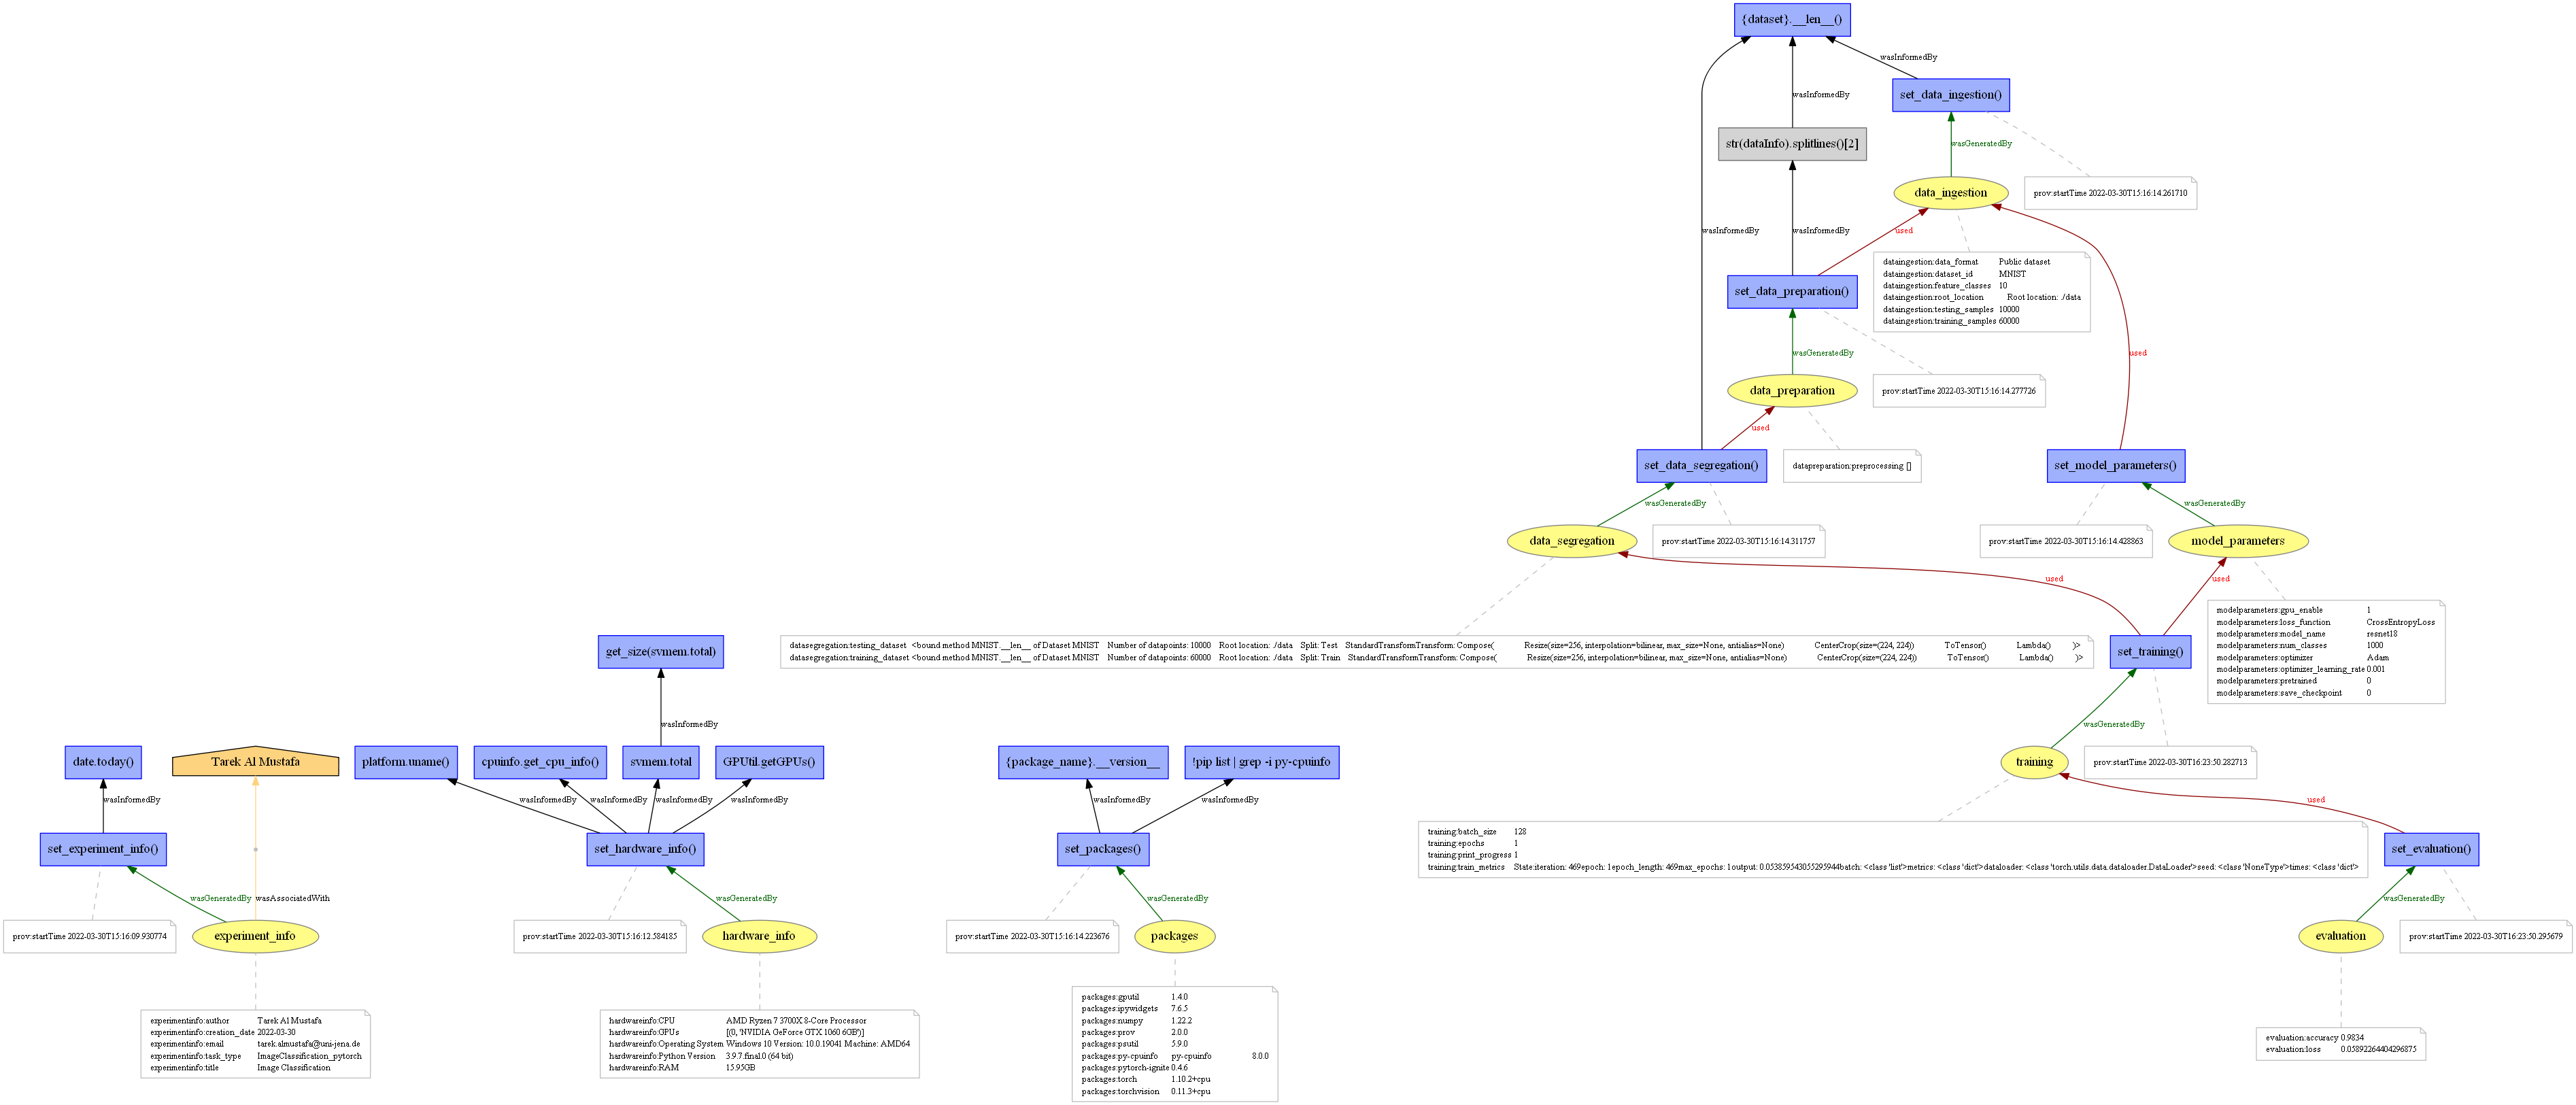

In [10]:
#add visualization to PATH
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#get time for filenames
timestring = time.strftime('%Y%m%d-%H%M%S')
timestring
ProvenanceNameImage = ('Provenance_ImageClassification_' + timestring + '.png')

dot = prov_to_dot(d1)
dot.write_png('../GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open = widgets.Button(description = 'Open Image File')
display(provenanceImage_open)

def on_button_clicked(b):
    provenanceImage_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open.on_click(on_button_clicked)
Image('../GeneratedProvenanceData/'+ProvenanceNameImage)

### Write Provenance Data

In [11]:
ProvenanceName = ('Provenance_ImageClassification_' + timestring + '.json')

with open('../GeneratedProvenanceData/'+ProvenanceName, 'w') as prov_file:
    prov_file.write(d1.serialize(indent=2))

### Open Provenance Data

In [12]:
provenance_open = widgets.Button(description = 'Open Provenance Data File')
display(provenance_open)

def on_button_clicked(b):
    provenance_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceName)

provenance_open.on_click(on_button_clicked)

Button(description='Open Provenance Data File', style=ButtonStyle())